In [66]:
# HIDDEN
using CSV
using DataFrames
using Statistics
using StatsPlots
Base.displaysize() = (5, 80)

In [2]:
# HIDDEN
using RDatasets
tips = dataset("reshape2", "tips");

In [71]:
# HIDDEN
"""
Uses gradient descent to minimize loss_fn. Returns the minimizing value of
theta_hat once theta_hat changes less than 0.0001 between iterations.
"""
function minimize(loss_fn, grad_loss_fn, x_vals, y_vals; alpha=0.0005, progress=true)
    theta = [0., 0.]
    loss = loss_fn(theta, x_vals, y_vals)
    while true
        if progress
            #println("theta: ", theta, " | loss: ", loss)
            println("theta: ", round.(theta; digits=2), " | cost: ", loss)
        end
        gradient = grad_loss_fn(theta, x_vals, y_vals)
        new_theta = theta .- alpha .* gradient
        new_loss = loss_fn(new_theta, x_vals, y_vals)
        
        if abs(new_loss - loss) < 0.0001
            return new_theta
        end
                
        theta = new_theta
        loss = new_loss
    end
end;

## Fitting a Linear Model Using Gradient Descent

We want to fit a linear model that predicts the tip amount based on the total bill of the table:

$$
f_\boldsymbol\theta (x) = \theta_1 x + \theta_0
$$

In order to optimize $ \theta_1 $ and $ \theta_0 $, we need to first choose a loss function. We will choose the mean squared error loss function:

$$
\begin{aligned}
L(\boldsymbol\theta, \textbf{x}, \textbf{y})
&= \frac{1}{n} \sum_{i = 1}^{n}(y_i - f_\boldsymbol\theta (x_i))^2\\
\end{aligned}
$$

Note that we have modified our loss function to reflect the addition of an explanatory variable in our new model. Now, $ \textbf{x} $ is a vector containing the individual total bills, $ \textbf{y} $ is a vector containing the individual tip amounts, and $ \boldsymbol\theta $ is a vector: $ \boldsymbol\theta = [ \theta_1, \theta_0 ] $.

Using a linear model with the squared error also goes by the name of least-squares linear regression. We can use gradient descent to find the $ \boldsymbol\theta $ that minimizes the loss.

**An Aside on Using Correlation**

If you have seen least-squares linear regression before, you may recognize that we can compute the correlation coefficient and use it to determine $ \theta_1 $ and $ \theta_0 $. This is simpler and faster to compute than using gradient descent for this specific problem, similar to how computing the mean was simpler than using gradient descent to fit a constant model. We will use gradient descent anyway because it is a general-purpose method of loss minimization that still works when we later introduce models that do not have analytic solutions. In fact, in many real-world scenarios, we will use gradient descent even when an analytic solution exists because computing the analytic solution can take longer than gradient descent, especially on large datasets.

## Derivative of the MSE Loss

In order to use gradient descent, we have to compute the derivative of the MSE loss with respect to $ \boldsymbol\theta $. Now that $ \boldsymbol\theta $ is a vector of length 2 instead of a scalar, $ \nabla_{\boldsymbol\theta} L(\boldsymbol\theta, \textbf{x}, \textbf{y}) $ will also be a vector of length 2.

$$
\begin{aligned}
\nabla_{\boldsymbol\theta} L(\boldsymbol\theta, \textbf{x}, \textbf{y})
&= \nabla_{\boldsymbol\theta} \left[ \frac{1}{n} \sum_{i = 1}^{n}(y_i - f_\boldsymbol\theta (x_i))^2 \right] \\
&= \frac{1}{n} \sum_{i = 1}^{n}2 (y_i - f_\boldsymbol\theta (x_i))(- \nabla_{\boldsymbol\theta} f_\boldsymbol\theta (x_i))\\
&= -\frac{2}{n} \sum_{i = 1}^{n}(y_i - f_\boldsymbol\theta (x_i))(\nabla_{\boldsymbol\theta} f_\boldsymbol\theta (x_i))\\
\end{aligned}
$$

We know:

$$
f_\boldsymbol\theta (x) = \theta_1 x + \theta_0
$$

We now need to compute $ \nabla_{\boldsymbol\theta} f_\boldsymbol\theta (x_i) $ which is a length 2 vector.

$$
\begin{aligned}
\nabla_{\boldsymbol\theta} f_\boldsymbol\theta (x_i)
&= \begin{bmatrix}
     \frac{\partial}{\partial \theta_0} f_\boldsymbol\theta (x_i)\\
     \frac{\partial}{\partial \theta_1} f_\boldsymbol\theta (x_i)
   \end{bmatrix} \\
&= \begin{bmatrix}
     \frac{\partial}{\partial \theta_0} [\theta_1 x_i + \theta_0]\\
     \frac{\partial}{\partial \theta_1} [\theta_1 x_i + \theta_0]
   \end{bmatrix} \\
&= \begin{bmatrix}
     1 \\
     x_i
   \end{bmatrix} \\
\end{aligned}
$$

Finally, we plug back into our formula above to get

$$
\begin{aligned}
\nabla_{\boldsymbol\theta} L(\theta, \textbf{x}, \textbf{y})
&= -\frac{2}{n} \sum_{i = 1}^{n}(y_i - f_\boldsymbol\theta (x_i))(\nabla_{\boldsymbol\theta} f_\boldsymbol\theta (x_i))\\
&= -\frac{2}{n} \sum_{i = 1}^{n} (y_i - f_\boldsymbol\theta (x_i)) \begin{bmatrix} 1 \\ x_i \end{bmatrix} \\
&= -\frac{2}{n} \sum_{i = 1}^{n} \begin{bmatrix}
    (y_i - f_\boldsymbol\theta (x_i)) \\
    (y_i - f_\boldsymbol\theta (x_i)) x_i
    \end{bmatrix} \\
\end{aligned}
$$

This is a length 2 vector since $ (y_i - f_\boldsymbol\theta (x_i)) $ is scalar.

## Running Gradient Descent

Now, let's fit a linear model on the tips dataset to predict the tip amount from the total table bill.

First, we define a Julia function to compute the loss:

In [55]:
"""Returns predictions by a linear model on x_vals."""
function simple_linear_model(thetas, x_vals)
    return thetas[1] .+ thetas[2] .* x_vals
end

function mse_loss(thetas, x_vals, y_vals)
    return mean((y_vals .- simple_linear_model(thetas, x_vals)) .^ 2)
end;

Then, we define a function to compute the gradient of the loss:

In [30]:
function grad_mse_loss(thetas, x_vals, y_vals)
    n = length(x_vals)
    grad_0 = y_vals .- simple_linear_model(thetas, x_vals)
    grad_1 = (y_vals .- simple_linear_model(thetas, x_vals)) .* x_vals
    return -2 / n .* [sum(grad_0), sum(grad_1)]
end;

In [31]:
# HIDDEN
thetas = [1, 1]
x_vals = [3, 4]
y_vals = [4, 5]
@assert isapprox(grad_mse_loss(thetas, x_vals, y_vals), [0, 0])

We'll use the previously defined `minimize` function that runs gradient descent, accounting for our new explanatory variable. It has the function signature (body omitted):

```julia
minimize(loss_fn, grad_loss_fn, x_vals, y_vals)
```

Finally, we run gradient descent!

In [74]:
@time thetas = minimize(mse_loss, grad_mse_loss, tips.TotalBill, tips.Tip);

theta: [0.0, 0.0] | cost: 10.896283606557377
theta: [0.0, 0.07] | cost: 3.8937622006094665
theta: [0.0, 0.1] | cost: 1.9359443267168217
theta: [0.01, 0.12] | cost: 1.3885384482860963
theta: [0.01, 0.13] | cost: 1.2354594169055337
theta: [0.01, 0.14] | cost: 1.1926273731479429
theta: [0.01, 0.14] | cost: 1.1806184944517064
theta: [0.01, 0.14] | cost: 1.1772272516962659
theta: [0.01, 0.14] | cost: 1.176245362431374
theta: [0.01, 0.14] | cost: 1.175937098098915
theta: [0.01, 0.14] | cost: 1.1758171789667662
  0.002892 seconds (3.14 k allocations: 203.844 KiB)


We can see that gradient descent converges to the theta values of $\hat\theta_0 = 0.01$ and $\hat\theta_1 = 0.14$. Our linear model is:

$$y = 0.14x + 0.01$$


We can use our estimated thetas to make and plot our predictions alongside the original data points.

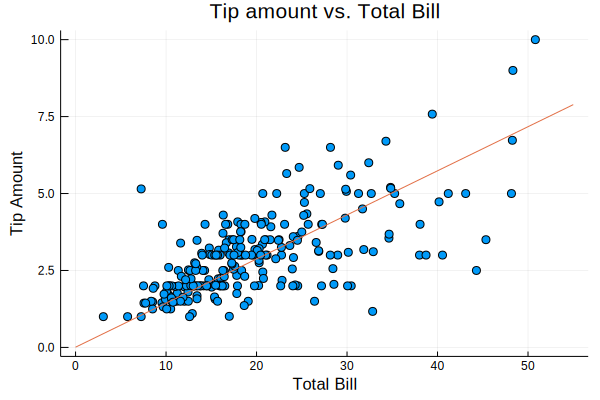

In [76]:
# HIDDEN
x_vals = [0, 55]
@df tips scatter(:TotalBill, :Tip, legend=false, title="Tip amount vs. Total Bill")
plot!(x_vals, simple_linear_model(thetas, x_vals))
xlabel!("Total Bill")
ylabel!("Tip Amount")

We can see that if a table's bill is $\$10$, our model will predict that the waiter gets around $\$1.50$ in tip. Similarly, if a table's bill is $\$40$, our model will predict a tip of around $\$6.00$.